In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import astropy.units as u

In [2]:
mp.rcParams['figure.figsize'] = (12, 8)

In [7]:
from context import lens
from lens.sie.inference import *

In [9]:
import emcee

# A simple Baysian model


## sources parameters $\theta_{src}$
* $g_S$
* $x_S$
* $y_S$

## SIE lens parameters $\theta_{SIE}$
* $b_L$ : Einstein's radius 
* $q_L$ : axis ratio
* $x_L$
* $y_L$
* $\theta_L$ : orientation


Text(0.5,0,'Magnitude radius prior')

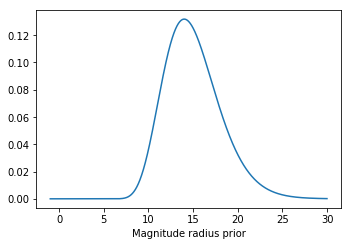

In [10]:
plt.subplot(221)
x = np.arange(-1,30,0.01)
y = [magnitudePrior(v) for v in x]
plt.plot(x,y)
plt.xlabel("Magnitude radius prior")

Text(0.5,0,'Lens orientation prior')

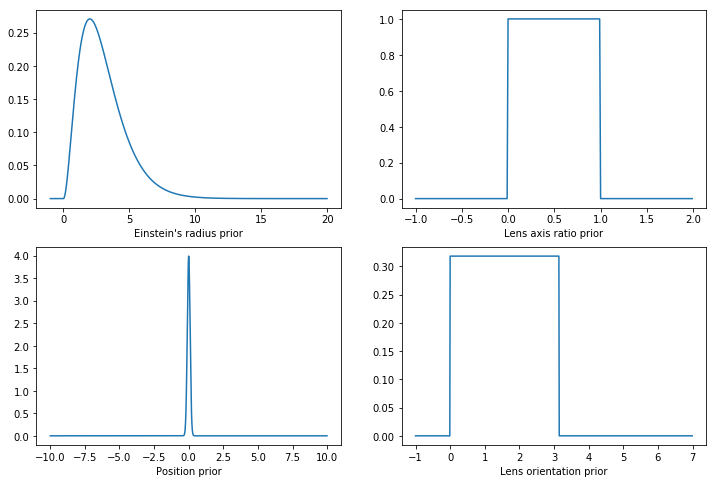

In [11]:
plt.subplot(221)
x = np.arange(-1,20,0.01)
y = [radiusPrior(v) for v in x]
plt.plot(x,y)
plt.xlabel("Einstein's radius prior")

plt.subplot(222)
x = np.arange(-1,2,0.01)
y = [ratioPrior(v) for v in x]
plt.plot(x,y)
plt.xlabel("Lens axis ratio prior")

plt.subplot(223)
x = np.arange(-10,10,0.01)
y = [positionPrior(v) for v in x]
plt.plot(x,y)
plt.xlabel("Position prior")

plt.subplot(224)
x = np.arange(-1,7,0.01)
y = [thetaPrior(v) for v in x]
plt.plot(x,y)
plt.xlabel("Lens orientation prior")

In [14]:
model = np.array([0.1,0.1,18,2,0.5,0,0,0.])
parameter = "xS,yS,gS,bL,qL,xL,yL,thetaL".split(',')

In [15]:
log_prior(model)

-0.2754641863136746

generate simulated true data using the model and more or less realistic errors

In [16]:
error = np.concatenate((np.ones((4,2))*0.001,np.ones((4,1))*0.01),axis=1)

In [17]:
data = np.concatenate((np.array(getImages(model)),error),axis=1)

In [18]:
np.around(data,3)

array([[ 2.3190e+00,  5.0000e-01,  1.7144e+01,  1.0000e-03,  1.0000e-03,
         1.0000e-02],
       [-4.3300e-01,  1.8370e+00,  1.8707e+01,  1.0000e-03,  1.0000e-03,
         1.0000e-02],
       [-1.8510e+00,  7.2500e-01,  1.6751e+01,  1.0000e-03,  1.0000e-03,
         1.0000e-02],
       [-2.3000e-01, -1.4770e+00,  1.9634e+01,  1.0000e-03,  1.0000e-03,
         1.0000e-02]])

In [19]:
log_likelihood(model,data)

27.210920789851304

In [20]:
log_posterior(model,data)

array(26.9354566)

In [21]:
ndim = len(model)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nsteps = 1000  # number of MCMC steps

In [22]:
np.random.seed(0)
def init(N):
    """ to initialise each walkers initial value : sets parameter randomly """
    xs = norm.rvs(0,0.2,size=N)
    ys = norm.rvs(0,0.2,size=N)
    gs = gamma.rvs(10,5,size=N)
    xl = norm.rvs(0,0.2,size=N)
    yl = norm.rvs(0,0.2,size=N)
    b = 2*beta.rvs(2,3,size=N)
    q =  np.random.uniform(0,1,N)
    theta = np.random.uniform(0,np.pi,N)
    return np.transpose(np.array([xs,ys,gs,b,q,xl,yl,theta]))

In [23]:
starting_guesses = init(nwalkers)

check that the initial values make sens with respect to the prior

In [24]:
np.std([log_prior(guess) for guess in starting_guesses])

2.4613953803354356

In [25]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])
%time x = sampler.run_mcmc(starting_guesses, nsteps)

/Users/abombrun/IPythonNB/Projects/Preparation4Stat/lens/sie/inference.py:38: RuntimeWarning: divide by zero encountered in log10
  res = res + np.log10(radiusPrior(b)) + np.log10(ratioPrior(q)) + np.log10(thetaPrior(theta))
/Users/abombrun/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/abombrun/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
/Users/abombrun/IPythonNB/Projects/Preparation4Stat/lens/sie/inference.py:36: RuntimeWarning: divide by zero encountered in log10
  res = np.log10(positionPrior(xs)) + np.log10(positionPrior(ys)) + np.log10(magnitudePrior(gs))


CPU times: user 1min 29s, sys: 512 ms, total: 1min 30s
Wall time: 1min 30s


with a prior on theta that does not restrict the lens orientation, i.e. multi modal distribution in theta, emcee sampling does not seem to behave very well!

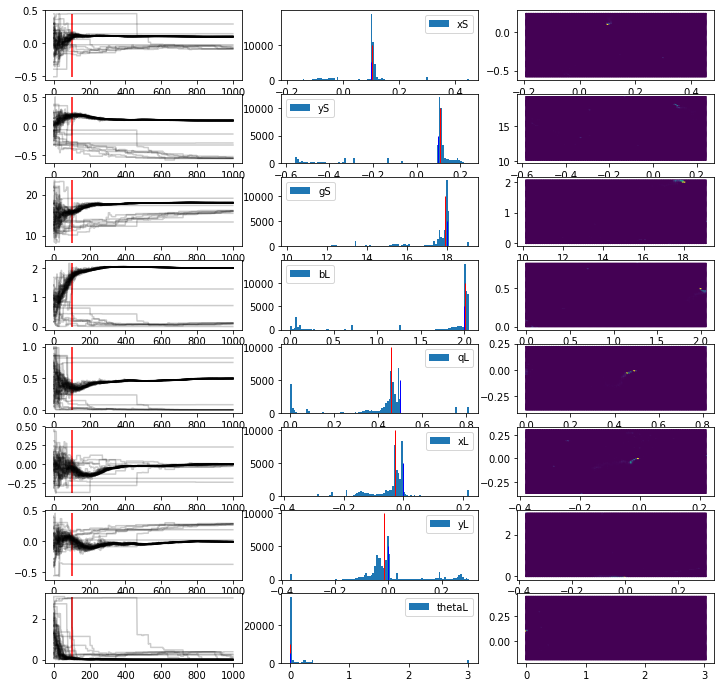

In [26]:
def plot_chains(sampler,warmup=100):
    fig, ax = plt.subplots(ndim,3, figsize=(12, 12))
    samples = sampler.chain[:, warmup:, :].reshape((-1, ndim))
    for i in range(ndim):
        ax[i,0].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);
        ax[i,0].vlines(warmup,np.min(sampler.chain[:, :, i].T),np.max(sampler.chain[:, :, i].T),'r')
        ax[i,1].hist(samples[:,i],bins=100,label=parameter[i]);
        ax[i,1].legend()
        ax[i,1].vlines(np.median(samples[:,i]),0,10000,lw=1,color='r',label="median")
        ax[i,1].vlines(np.median(model[i]),0,5000,lw=1,color='b',label="true")
        ax[i,2].hexbin(samples[:,i],samples[:,(i+1)%ndim])#,s=1,alpha=0.1);
plot_chains(sampler)

tune the starting value around the expected results

In [27]:
np.random.seed(0)
def init2(N):
    """ to initialise each walkers initial value : sets parameter randomly """
    xs = norm.rvs(0.1,0.05,size=N)
    ys = norm.rvs(0.1,0.05,size=N)
    gs = norm.rvs(18,0.5,size=N)
    xl = norm.rvs(0,0.05,size=N)
    yl = norm.rvs(0,0.05,size=N)
    b  = norm.rvs(2,0.1,size=N)
    q  = norm.rvs(0.5,0.1,size=N)
    theta = np.random.uniform(0,np.pi,N)
    return np.transpose(np.array([xs,ys,gs,b,q,xl,yl,theta]))

starting_guesses = init2(nwalkers)

In [28]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])
%time x = sampler.run_mcmc(starting_guesses, nsteps)

/Users/abombrun/IPythonNB/Projects/Preparation4Stat/lens/sie/inference.py:38: RuntimeWarning: divide by zero encountered in log10
  res = res + np.log10(radiusPrior(b)) + np.log10(ratioPrior(q)) + np.log10(thetaPrior(theta))
/Users/abombrun/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/abombrun/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


CPU times: user 1min 39s, sys: 584 ms, total: 1min 40s
Wall time: 1min 40s


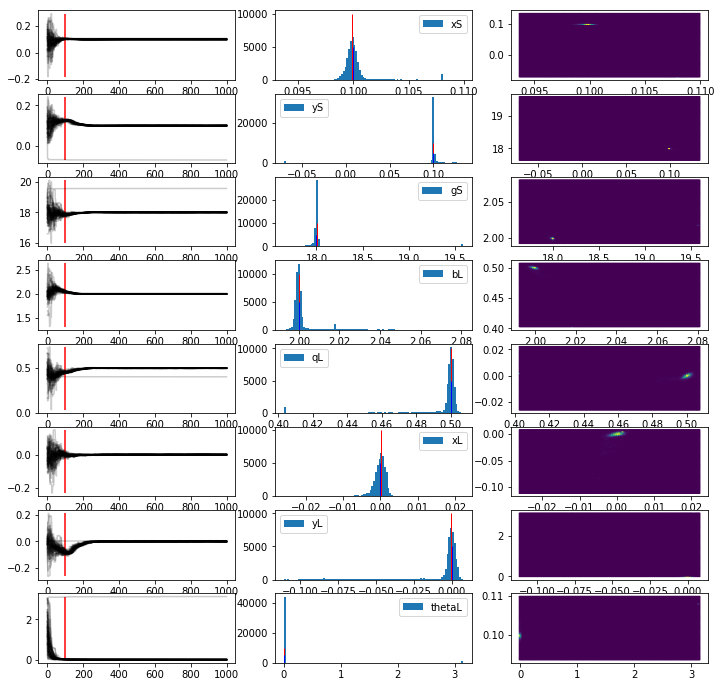

In [29]:
plot_chains(sampler)